In [1]:
from xml_tools import get_abstract_contents
from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel
from sklearn.cluster import KMeans
import pandas as pd
from sklearn.decomposition import PCA
import numpy as np
from scipy.spatial import distance_matrix
from sklearn import manifold
from tqdm import tqdm

In [2]:
import glob
from os import path



In [3]:
import spacy
nlp = spacy.load("en_core_web_lg")

In [4]:
xmls = glob.glob('../articles_from_tatiana/review_revenue_header_xml/*.xml')

xmls[:10]

['../articles_from_tatiana/review_revenue_header_xml/Zhang et al 2010.pdf.xml',
 '../articles_from_tatiana/review_revenue_header_xml/Pal et al. 2018.pdf.xml',
 '../articles_from_tatiana/review_revenue_header_xml/Gong et al 2018.pdf.xml',
 '../articles_from_tatiana/review_revenue_header_xml/Linh and Hong  2009-Channel coordination through a revenue sharing contract.pdf.xml',
 '../articles_from_tatiana/review_revenue_header_xml/Cao et al-2013-IJPE.pdf.xml',
 '../articles_from_tatiana/review_revenue_header_xml/Buratto et al - 2019.pdf.xml',
 '../articles_from_tatiana/review_revenue_header_xml/Hsueh 2014-Improving corporate social responsibility in a supply chain through a new revenue sharing contract.pdf.xml',
 '../articles_from_tatiana/review_revenue_header_xml/Lee and Rhee-2010-IJPE.pdf.xml',
 '../articles_from_tatiana/review_revenue_header_xml/Avinadav et al. 2019-IJPE.pdf.xml',
 '../articles_from_tatiana/review_revenue_header_xml/Shen et al-2019-POMS.pdf.xml']

In [5]:
article_abstract_dict = {path.basename(x).rsplit('.',2)[0]: get_abstract_contents(x) for x in xmls}

In [6]:
for k, v in article_abstract_dict.items():
    print(f'{k}: {v[:60]}... ({len(v)})\n')
#article_abstract_dict.__repr__()[:1000]

Zhang et al 2010: With the emergence of virtual market places, consignment sel... (1017)

Pal et al. 2018: Uncertainty is a major challenging factor in the marketing s... (1036)

Gong et al 2018: The information technology (IT) capabilities of third-party ... (1614)

Linh and Hong  2009-Channel coordination through a revenue sharing contract: This paper studies channel coordination through revenue shar... (772)

Cao et al-2013-IJPE: This paper develops a coordination mechanism for a supply ch... (1290)

Buratto et al - 2019: This paper investigates whether a supply chain can achieve c... (1354)

Hsueh 2014-Improving corporate social responsibility in a supply chain through a new revenue sharing contract: Due to the social and environmental impacts of industrial ac... (1450)

Lee and Rhee-2010-IJPE: Numerous studies have offered diverse contractual forms of a... (1761)

Avinadav et al. 2019-IJPE: Virtual products, such as mobile apps, 3D print files, e-mus... (1737)

Shen et al-2019-POM

In [7]:
Counter([min(len(v),500) for v in article_abstract_dict.values()])

Counter({500: 123, 0: 9, 339: 1, 422: 1, 368: 1, 433: 1})

In [8]:
article_abstract_dict = {k: v for k,v in article_abstract_dict.items() if len(v)>0}

In [9]:
bywords = {
    'rs','revenue share contract','revenue sharing contract','revenue sharing','rs contract','contract'
}
def spacy_clean_tokenizer(document, chunks=True):
    tokens = nlp(document)
    tokens = [token.lemma_ for token in (tokens.noun_chunks if chunks else tokens)  if (
        (chunks or token.is_stop == False) and 
        (chunks or token.is_punct == False) and 
        token.lemma_.strip()!= ''
    )]
    tokens = [ ' '.join([tk.lemma_ for tk in nlp(token) if not (tk.is_stop or tk.is_punct)]) 
              for token in tokens
             ]
    tokens = [tk for tk in tokens if len(tk) and tk not in bywords]
    return tokens

In [10]:
sorted(spacy_clean_tokenizer(list(article_abstract_dict.values())[1]))

['behavior',
 'chance factor',
 'condition',
 'demand uncertainty',
 'effect',
 'environment',
 'extra product',
 'feasibility',
 'flexible ordering policy',
 'graphical illustration',
 'key parameter',
 'major challenging factor',
 'manufacturer',
 'manufacturer',
 'manufacturer',
 'manufacturer Stackelberg revenue sharing contract',
 'marketing strategy',
 'model',
 'model',
 'model',
 'numerical example',
 'optimal decision',
 'penalty',
 'player',
 'propose model',
 'random yield',
 'random yield',
 'range',
 'salvage value',
 'sensitivity',
 'share',
 'stock',
 'stocking overstock risk',
 'study',
 'supplier',
 'supplier production',
 'supply chain',
 'uncertainty',
 'vertical Nash approach']

In [11]:
print([len(v.split()) for v in article_abstract_dict.values()])

[154, 159, 233, 115, 180, 195, 214, 242, 251, 231, 200, 144, 164, 261, 299, 158, 87, 253, 170, 111, 227, 98, 216, 132, 146, 51, 273, 181, 147, 55, 175, 102, 181, 151, 177, 216, 97, 176, 150, 125, 161, 220, 159, 156, 146, 124, 202, 243, 178, 189, 172, 167, 123, 183, 114, 141, 259, 275, 127, 216, 230, 174, 125, 197, 143, 223, 130, 159, 174, 184, 144, 213, 260, 220, 232, 191, 94, 214, 308, 235, 218, 198, 233, 161, 182, 99, 234, 144, 141, 132, 189, 196, 126, 93, 198, 188, 96, 193, 209, 55, 254, 107, 225, 196, 217, 197, 152, 182, 112, 213, 125, 103, 220, 97, 124, 115, 146, 197, 100, 248, 158, 227, 62, 83, 101, 144, 198]


In [12]:
tfidf_vectorizer = TfidfVectorizer(input = 'content', tokenizer = spacy_clean_tokenizer)

result = tfidf_vectorizer.fit_transform(iter(article_abstract_dict.values()))
result


<127x2350 sparse matrix of type '<class 'numpy.float64'>'
	with 3937 stored elements in Compressed Sparse Row format>

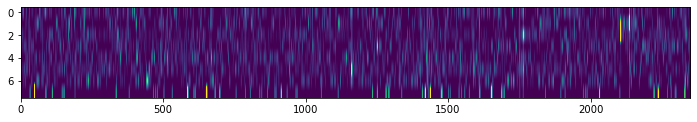

In [13]:
n_clusters=8
kmeans = KMeans(n_clusters=8,random_state=1015).fit(result)

kmeans.cluster_centers_.shape

import matplotlib.pyplot as plt
plt.figure(figsize=(12,4))
plt.imshow(kmeans.cluster_centers_,aspect=40,vmax=0.03)

In [14]:

mean_coord = kmeans.cluster_centers_.mean(axis=0)
mean_words = sorted(zip(mean_coord, tfidf_vectorizer.get_feature_names()),reverse=True)[:12]
mean_words

[(0.05524830375259798, 'retailer'),
 (0.052887468018975745, 'manufacturer'),
 (0.05035351198375475, 'agency model'),
 (0.048438265353476326, 'supply chain'),
 (0.04562874113265929, 'supplier'),
 (0.028782155658413924, 'paper'),
 (0.027099697426240115, 'model'),
 (0.021541162775703573, 'result'),
 (0.01967885520322156, 'profit'),
 (0.018721002254230436, 'pareto zone'),
 (0.018446921036265503, 'coordination'),
 (0.01840030371804217, 'publisher')]

In [15]:
cc = kmeans.cluster_centers_
k = []
for i in range(n_clusters):
    k.append(sorted(zip(cc[i,:]-mean_coord, tfidf_vectorizer.get_feature_names()),reverse=True)[:12])

k[:2]

[[(0.04770149053430676, 'firm'),
  (0.04334093251445584, 'cooperative program'),
  (0.04267023944669729, 'app'),
  (0.03693210094349708, 'consignment contract'),
  (0.036402397800760516, 'chain'),
  (0.03557162937350536, 'vendor'),
  (0.03373537018726707, 'reliability'),
  (0.029919623676610302, '3pl provider'),
  (0.029848140186169162, 'r'),
  (0.028696004762798693, 'partner'),
  (0.02591157940619003, 'developer'),
  (0.025566281145788496, 'price discount mechanism')],
 [(0.11250168646366356, 'supply chain'),
  (0.05524634584904903, 'supplier'),
  (0.04069620868574915, 'insurance contract'),
  (0.039006957284817595, 'buyer'),
  (0.03484732101070405, 'decision sequence'),
  (0.03220977770425959, 'loss averse retailer'),
  (0.03155417451185569, 'er'),
  (0.03136026850380576, 'coordination'),
  (0.03109813389296221, 'uncertainty'),
  (0.03064541533213057, 'risk diversification contract'),
  (0.02754918328254716, 'flexible ordering policy'),
  (0.027521005836425052, 'competition')]]

In [16]:
k50 = []
for i in range(n_clusters):
    k50.append(sorted(zip(cc[i,:]-mean_coord, tfidf_vectorizer.get_feature_names()),reverse=True)[:50])



In [17]:
k50[0]

[(0.04770149053430676, 'firm'),
 (0.04334093251445584, 'cooperative program'),
 (0.04267023944669729, 'app'),
 (0.03693210094349708, 'consignment contract'),
 (0.036402397800760516, 'chain'),
 (0.03557162937350536, 'vendor'),
 (0.03373537018726707, 'reliability'),
 (0.029919623676610302, '3pl provider'),
 (0.029848140186169162, 'r'),
 (0.028696004762798693, 'partner'),
 (0.02591157940619003, 'developer'),
 (0.025566281145788496, 'price discount mechanism'),
 (0.02478817274212764, 'cooperative advertising program'),
 (0.02394604308715412, 'service level'),
 (0.023640686056573525, 'supply chain member'),
 (0.023442793869574825, 'member'),
 (0.023123558225601016, 'equilibrium strategy'),
 (0.022987122796371134, 'investment'),
 (0.022529792384142083, 'sale'),
 (0.022490246791511383, 'rsr contract'),
 (0.022159636224660953, 'retailer'),
 (0.021406110128505025, 'deteriorate item'),
 (0.021063740002470514, 'manufacturer profit'),
 (0.020756391979896864, 'stackelberg leader'),
 (0.020737329952

In [18]:
df = pd.concat([pd.DataFrame(data=v, columns= ['score','words']) for i,v in enumerate(k)],axis=0)
df['cluster'] = sum([[i]*12 for i in range(n_clusters)],[]) 
df = df[df.columns[::-1]]
df

,cluster,words,score
0,0,firm,0.047701
1,0,cooperative program,0.043341
2,0,app,0.042670
3,0,consignment contract,0.036932
4,0,chain,0.036402
...,...,...,...
7,7,publish,0.089592
8,7,new digital economy,0.089592
9,7,negative attention,0.089592
10,7,entertainment,0.089592


In [19]:
df.groupby('cluster')['words'].apply( lambda w: '; '.join(w))

cluster
0    firm; cooperative program; app; consignment co...
1    supply chain; supplier; insurance contract; bu...
2    supplier; retailer; consignment contract; whol...
3    model; system; quick response; rq; tape; owner...
4    coordination mechanism; effect; consumer; m&a;...
5    manufacturer; customer; retailer; impact; pape...
6    csr; wholesale price; jstor; channel coordinat...
7    agency model; pareto zone; publisher; digital ...
Name: words, dtype: object

In [20]:
pwd

'/home/siegman/Documents/Shahar/years/y2021/t_and_t/code'

In [21]:
df.to_excel('revenue_review_tf_idf_cluster_main_words.xlsx', index=False)

In [22]:
kmeans.predict(result)


array([3, 3, 0, 6, 4, 0, 6, 4, 5, 5, 0, 5, 2, 6, 2, 2, 6, 0, 2, 1, 4, 0,
       1, 4, 2, 7, 5, 6, 5, 3, 1, 1, 4, 4, 2, 5, 1, 1, 3, 5, 0, 5, 3, 4,
       1, 0, 5, 3, 2, 5, 0, 4, 2, 5, 1, 3, 2, 1, 4, 5, 3, 0, 3, 5, 6, 4,
       3, 0, 6, 5, 2, 3, 7, 4, 5, 2, 3, 1, 5, 4, 2, 2, 5, 2, 5, 3, 6, 2,
       0, 3, 2, 0, 2, 5, 0, 1, 6, 2, 5, 3, 0, 5, 0, 2, 7, 5, 4, 2, 5, 4,
       3, 2, 2, 1, 2, 6, 2, 0, 1, 4, 2, 3, 6, 6, 6, 5, 5], dtype=int32)

In [50]:
cluster_affinity = np.array([3, 3, 0, 6, 4, 0, 6, 4, 5, 5, 0, 5, 2, 6, 2, 2, 6, 0, 2, 1, 4, 0,
       1, 4, 2, 7, 5, 6, 5, 3, 1, 1, 4, 4, 2, 5, 1, 1, 3, 5, 0, 5, 3, 4,
       1, 0, 5, 3, 2, 5, 0, 4, 2, 5, 1, 3, 2, 1, 4, 5, 3, 0, 3, 5, 6, 4,
       3, 0, 6, 5, 2, 3, 7, 4, 5, 2, 3, 1, 5, 4, 2, 2, 5, 2, 5, 3, 6, 2,
       0, 3, 2, 0, 2, 5, 0, 1, 6, 2, 5, 3, 0, 5, 0, 2, 7, 5, 4, 2, 5, 4,
       3, 2, 2, 1, 2, 6, 2, 0, 1, 4, 2, 3, 6, 6, 6, 5, 5],
      dtype=np.int32)

In [24]:
# cluster_affinity = np.array([5, 7, 2, 3, 3, 4, 3, 1, 3, 4, 5, 4, 5, 3, 5, 5, 2, 6, 5, 5, 1, 6,
#        5, 4, 5, 3, 1, 3, 3, 6, 5, 5, 5, 4, 5, 2, 5, 5, 4, 3, 1, 4, 4, 2,
#        4, 0, 6, 2, 7, 5, 4, 2, 2, 2, 4, 5, 2, 5, 4, 0, 2, 1, 4, 1, 7, 5,
#        3, 3, 7, 5, 3, 2, 5, 7, 7, 1, 3, 5, 1, 6, 2, 0, 5, 4, 0, 5, 4, 7,
#        3, 5, 4, 4, 2, 2, 5, 1, 3, 7, 3, 5, 5, 6, 6, 2, 1, 1, 2, 4, 7, 5,
#        5, 5, 2, 3, 5, 1, 5, 1, 5, 3, 5, 3, 5, 0, 7, 5, 6, 3, 5, 3, 4],
#       dtype=np.int32)

In [51]:
cluster_sets =[[x[1] for x in k] for k in k50]

In [26]:
article_tokens = {k: set(spacy_clean_tokenizer(v)) for k,v in article_abstract_dict.items()}

In [52]:
from collections import Counter
c = Counter()
for v in article_tokens.values():
    c.update(v)
    

In [53]:
len(c)

2347

In [54]:
def get_article_indetifiers():
    for (article_name, article_words), cluster  in \
            zip(article_tokens.items(), tqdm(cluster_affinity)):
        cluster_words = cluster_sets[cluster]
        joint_words = [word for word in cluster_words if word in article_words and c[word]>=3][:15]
        yield article_name, cluster, joint_words

In [55]:
cluster_summary = pd.DataFrame(
        data=list(get_article_indetifiers()), 
        columns = 'article_name, cluster, article_words'.split(', ')
    )

cluster_summary['article_words'] = cluster_summary.article_words.map(', '.join)
cluster_summary = cluster_summary.sort_values(['cluster','article_name'])
cluster_summary

 99%|█████████▉| 126/127 [00:00<00:00, 87265.90it/s]


,article_name,cluster,article_words
100,Avinadav et al 2015a,0,"consignment contract, supply chain member, equ..."
45,Avinadav et al.- 2015b,0,"consignment contract, supply chain member, equ..."
5,Buratto et al - 2019,0,"cooperative program, consignment contract, ret..."
91,Cai et al 2017-Flexible contract design for V...,0,"member, finding, inventory, risk"
88,Chakraborty et al 2018,0,"chain, partner, retailer, manufacturer"
...,...,...,...
122,Wang et al 2012-Three revenue-sharing variants...,6,
115,Xie et al 2017,6,"wholesale price, revenue sharing ratio, channel"
104,Lu et al-2018-EJOR,7,"agency model, publisher, benefit"
72,Tan_Carrillo-2017,7,"agency model, publisher, benefit"


In [56]:
cluster_summary.to_excel('revenue_review_tf_idf3.xlsx', index=False)

In [57]:
article_tokens['Xie et al 2017']

{'analysis',
 'background',
 'centralized decentralize dual channel close loop supply chain',
 'centralized decision',
 'change parameter valuation',
 'channel',
 'consideration',
 'decentralized decision',
 'feature',
 'influence',
 'manufacturing',
 'numeric example',
 'online offline dual channel',
 'online offline price',
 'optimal online offline price',
 'optimal profit',
 'recycle rate',
 'recycle rate fluctuation',
 'recycle revenue sharing ratio',
 'relationship',
 'revenue share mechanism',
 'revenue sharing ratio',
 'variable',
 'wholesale price',
 'wholesale price advertising investment'}

In [58]:
df2 = pd.DataFrame({'file_name': list(article_abstract_dict.keys()), 'cluster': kmeans.predict(result)})
df2=df2.sort_values(['cluster','file_name'])

In [59]:
word_series = df.groupby('cluster')['words'].apply( lambda w: '; '.join(w))
df2['words']=''
for cl,gr in df2.groupby('cluster'):
#     print(cl)
#     print(gr.columns)
    df2['words'][gr['words'].index[0]] = word_series[cl]

<ipython-input-59-14fec56918fb>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['words'][gr['words'].index[0]] = word_series[cl]


In [60]:
df2

,file_name,cluster,words
100,Avinadav et al 2015a,0,firm; cooperative program; app; consignment co...
45,Avinadav et al.- 2015b,0,
5,Buratto et al - 2019,0,
91,Cai et al 2017-Flexible contract design for V...,0,
88,Chakraborty et al 2018,0,
...,...,...,...
122,Wang et al 2012-Three revenue-sharing variants...,6,
115,Xie et al 2017,6,
104,Lu et al-2018-EJOR,7,agency model; pareto zone; publisher; digital ...
72,Tan_Carrillo-2017,7,


In [61]:
kmeans.cluster_centers_.shape


(8, 2350)

In [62]:
df2.to_excel('revenue_review_tf_idf_cluster_contents3.xlsx',sheet_name='clusters', index=False)

In [63]:
pd.__version__

'1.2.2'

In [64]:
cluster_centers_pca = PCA()
cluster_centers_pca.fit(kmeans.cluster_centers_)

PCA()

In [65]:
np.round(np.cumsum(cluster_centers_pca.explained_variance_ratio_),3)

array([0.459, 0.579, 0.681, 0.773, 0.854, 0.933, 1.   , 1.   ])

In [66]:
cluster_centers_pca.components_ 

array([[-1.29153919e-03, -1.31394368e-03, -1.29153919e-03, ...,
        -2.18344399e-03, -1.28658316e-03, -2.03691418e-03],
       [ 9.19724299e-03, -4.09620889e-03,  9.19724299e-03, ...,
         1.80118337e-02, -4.01091269e-03, -3.37730351e-03],
       [-1.61371564e-03, -7.02279589e-03, -1.61371564e-03, ...,
         1.13918607e-02, -6.87655877e-03, -1.28153296e-02],
       ...,
       [-6.81267579e-03, -3.06403729e-05, -6.81267579e-03, ...,
         9.39258330e-03, -3.00023421e-05,  2.56955107e-02],
       [-4.67486978e-03,  1.83340532e-02, -4.67486978e-03, ...,
         9.81050677e-03,  1.79522794e-02, -1.71101535e-02],
       [ 4.06176685e-02,  3.93906690e-01, -2.64064094e-01, ...,
        -3.52916886e-03, -2.85159102e-03,  4.86067153e-03]])

In [67]:
cluster_centers_pca = PCA(2)
emb = cluster_centers_pca.fit_transform(kmeans.cluster_centers_)

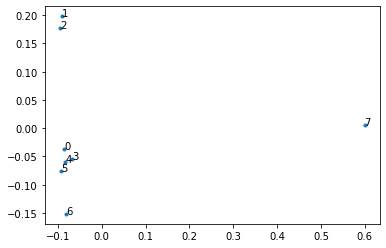

In [68]:
plt.plot(emb[:,0], emb[:,1],'.')

for i,r in enumerate(emb):
    plt.text(r[0],r[1],str(i))

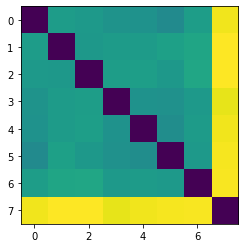

In [69]:
plt.imshow(distance_matrix(kmeans.cluster_centers_, kmeans.cluster_centers_))

In [70]:
np.round(distance_matrix(kmeans.cluster_centers_, kmeans.cluster_centers_).mean(axis=0),3)

array([0.385, 0.404, 0.402, 0.385, 0.387, 0.382, 0.405, 0.642])

In [71]:

mds = manifold.MDS(n_components=2, dissimilarity="euclidean", random_state=6)
results = mds.fit(kmeans.cluster_centers_)

coords = results.embedding_


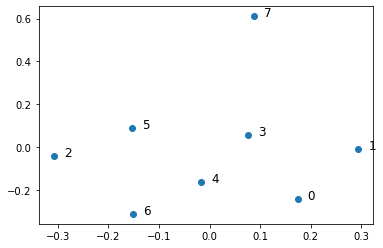

In [72]:
plt.plot(coords[:,0], coords[:,1],'o')

for i,r in enumerate(coords):
    plt.text(r[0]+0.02,r[1],str(i),fontsize=12)

In [48]:
result.shape

(127, 2350)

In [49]:
point_coord = []
for cl in range(8):
    points = result[cluster_affinity==cl,:] - kmeans.cluster_centers_[i,:]
    
    points2d = mds.fit(points).embedding_ + coords[i,:]
    point_coord.append(points2d)

IndexError: index (127) out of range

In [ ]:
point_stats = []
for cl in range(8):
    points_dist = distance_matrix(result[cluster_affinity==cl,:].todense(),kmeans.cluster_centers_)
    points_dist = (points_dist**2).mean(axis=0)
    point_stats.append(points_dist)

In [ ]:
plt.imshow(np.vstack(point_stats))

In [ ]:
np.round(np.vstack(point_stats),3)

In [ ]:
import matplotlib.cm as cm

In [ ]:

for i,r in enumerate(coords):
    plt.plot(coords[i,0], coords[i,1],'o',color = cm.tab20(i))
    plt.plot(coords[i,0], coords[i,1],'d',color = cm.tab20(i))

    plt.plot(point_coord[i][:,0], point_coord[i][:,1],'.',color = cm.tab20(i))

In [ ]:
points2d

In [ ]:
result[cluster_affinity==2,:].todense().shape